# Wavenet for time series prediction

In this tutorial, we show how to quickly set up and train an CNN regression model with the deep4cast package. The dataset we're using is from the GEFCom2014 forecasting competition and involved hourly energy load forecasting.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from deep4cast.forecasters import Forecaster
import deep4cast.topologies as topologies

import deep4cast.custom_metrics as metrics
from pandas import read_table

%matplotlib inline

# Fix random number seed for reproducibility
np.random.seed(3) 

Using TensorFlow backend.


## Data preparation

In [2]:
# Load the data from file
filename = '../data/energy.csv'
df = read_table(filename, sep=',')

# Prepare the data set
data = df[['load', 'temp']].astype('float32').values
data = np.expand_dims(data, axis=0)

# We just need a small holdout dataset for evaluation purposes
holdout = 24 # hours
train_data = data[:,:-holdout,[0]]
test_data = data[:,-holdout:,[0]]

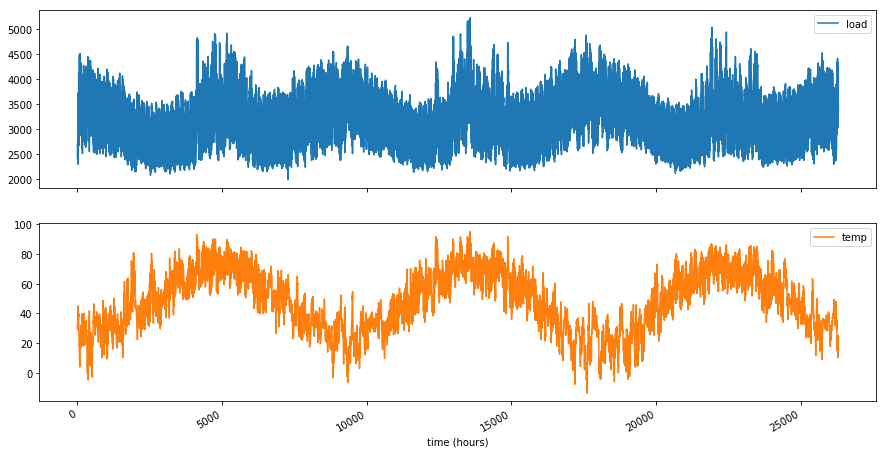

In [3]:
# Let plot the data
df.plot(subplots=True, figsize=(15, 8))
plt.xlabel('time (hours)')
plt.show()

# Modeling

In [4]:
topology = topologies.WaveNet(num_filters=32, num_layers=4)

In [5]:
forecaster = Forecaster(
    topology,
    lag=48,  # This is the number of time steps used to predict the future for each data point
    horizon=24,  # This is how many time steps into the future we want to produce
    lr=0.001,  # This is the learning rate for the optimizer
    epochs=100
)

In [6]:
forecaster.fit(train_data, targets=[0], verbose=1)

Epoch 1/100
26209/26209 [==============================] - 24s 915us/step - loss: 1.9441
Epoch 2/100
26209/26209 [==============================] - 19s 736us/step - loss: 0.0468
Epoch 3/100
26209/26209 [==============================] - 20s 752us/step - loss: -0.4928
Epoch 4/100
26209/26209 [==============================] - 19s 738us/step - loss: -0.7458
Epoch 5/100
26209/26209 [==============================] - 18s 680us/step - loss: -0.9155
Epoch 6/100
26209/26209 [==============================] - 20s 764us/step - loss: -1.0519
Epoch 7/100
26209/26209 [==============================] - 20s 776us/step - loss: -1.1784
Epoch 8/100
26209/26209 [==============================] - 21s 787us/step - loss: -1.2949
Epoch 9/100
26209/26209 [==============================] - 19s 726us/step - loss: -1.4034
Epoch 10/100
26209/26209 [==============================] - 17s 634us/step - loss: -1.5132
Epoch 11/100
26209/26209 [==============================] - 17s 653us/step - loss: -1.6131
Epoch 12/1

Epoch 91/100
26209/26209 [==============================] - 20s 752us/step - loss: -3.0590
Epoch 92/100
26209/26209 [==============================] - 19s 739us/step - loss: -3.0684
Epoch 93/100
26209/26209 [==============================] - 20s 747us/step - loss: -3.0483
Epoch 94/100
26209/26209 [==============================] - 19s 740us/step - loss: -3.0771
Epoch 95/100
26209/26209 [==============================] - 20s 750us/step - loss: -3.0635
Epoch 96/100
26209/26209 [==============================] - 20s 762us/step - loss: -3.0969
Epoch 97/100
26209/26209 [==============================] - 19s 733us/step - loss: -3.0973
Epoch 98/100
26209/26209 [==============================] - 19s 743us/step - loss: -3.0906
Epoch 99/100
26209/26209 [==============================] - 19s 737us/step - loss: -3.1082
Epoch 100/100
26209/26209 [==============================] - 19s 730us/step - loss: -3.0005


Text(0,0.5,'Loss')

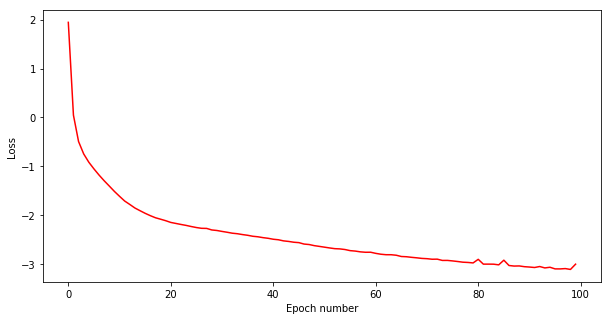

In [11]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.xlabel('Epoch number')
plt.ylabel('Loss')

# Evaluation

In [12]:
predictions = forecaster.predict(data=train_data, n_samples=1000)

In [13]:
print('MSE: {}'.format(round(metrics.mse(predictions['mean'], test_data[:,:,:1]), 2)))
print('MAPE: {}%'.format(round(metrics.mape(predictions['mean'], test_data[:,:,:1]), 2)))
print('SMAPE: {}%'.format(round(metrics.smape(predictions['mean'], test_data[:,:,:1]), 2)))

MSE: 29805.24
MAPE: 3.46%
SMAPE: 3.39%


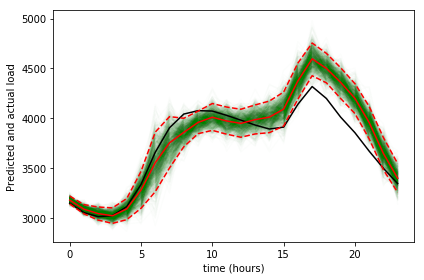

In [14]:
# We're printing the test set data and the predictions for the load data
plt.plot(predictions['samples'][:,0,:,0].T, 'g', alpha=0.01)
plt.plot(test_data[0,:,0].T, 'k')
plt.plot(predictions['mean'][0,:,0], 'r')
plt.plot(predictions['lower_quantile'][0,:,0], 'r--')
plt.plot(predictions['upper_quantile'][0,:,0], 'r--')
plt.xlabel('time (hours)')
plt.ylabel('Predicted and actual load')
plt.tight_layout()